#  Training an MLP from scratch

**Nom** : Senhadji M Said

# Necessary Packages


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1- Initialization
Write the function ``init_params(nx, nh, ny)``

In [2]:
def init_params(nx, nh, ny): 
    W1 = np.random.normal(loc=0, scale=0.3, size=(nh, nx+1)).astype(np.float32)
    W2 = np.random.normal(loc=0, scale=0.3, size=(ny, nh+1)).astype(np.float32)
    return [W1, W2]

## Forward propagation

### Activation Functions:
- `tanh(z)` : Hyperbolic tangent activation function
- `sigmoid(z)` : Standard sigmoid function
- `softmax(z)` : Converts logits into probabilities, with a numerical stability trick `z.max(axis=0)` to prevent overflow.
 

In [3]:
def tanh(z):
    return np.tanh(z)


In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
def softmax(z):
    t = np.exp(z - np.max(z, axis=0, keepdims=True))  
    return t / np.sum(t, axis=0, keepdims=True)

### `forward` function
1. **inputs**:
   - `params` : List of wight matrices for each layer.
   - `X`: Input data of shape `(n_batch, nx)`
   - `activation`: List of activation functions to be used for each layer
2. **Processing**: 
   - The input `X` is transposed `(Y = X.T)` to match matrix multiplication dimensions.
   - The function loops through each weight matrix (`W`) and activation function (`activation`).
   - **Bias Handling**: Adds a row of ones to Y to account for bias terms.
   - Computes `Z = W @ Y` (weighted sum).
   - Applies the activation function : `Y = activation(Z)`.
   - Stores both `Z` (pre-activation) and `Y` (post-activation) in `outputs`.
3. **Returns**: 
   - `outputs`: A list of intermediate values, as `[Z, Y]`.

In [6]:
def forward(params, X, activations):
    Y = X.T  
    outputs = []

    for W, activation in zip(params, activations):
        Y = np.vstack([np.ones((1, Y.shape[1])), Y])  
        Z = W @ Y  # Linear transformation
        Y = activation(Z)  
        outputs.append([Z, Y])  

    return outputs

## Loss & Accuracy
### Loss Calculation (Categorical Cross-Entropy)
For multi-class classification, we typically use categorical cross-entropy loss, which is defined as:
$$ L = - \frac{1}{N} \sum_{i=1}^{N}{\sum_{j=1}^{C}{y_{i,j}log(\hat{y}_{i,j})}}  $$
where:
  - $N$ is the number of samples.
  - $C$ is the number of classes.
  - $y_{i,j}$ is the actual label for sample $i$, class $j$.
  - $\hat{y}_{i,j}$ is the predicted probability for sample $i$, class $j$.

### Accuracy Calculation
$$ \text{Accurancy} = \frac{1}{N}\sum_{i=1}^N{1(\arg \max{\hat{y_i}} = \arg \max{y_i})} $$
where: 
- $\arg \max{y_i}$ : finds the index of the correct class (ground truth label)
- $\arg \max{\hat{y_i}}$ : finds the index of the predicted class
- $1(.)$ : s an indicator function that returns $1$ if the predicted class matches the true class, otherwise $0$.


In [7]:
def loss_accuracy(y_hat, y):
    loss = -np.mean(np.log(np.sum(y_hat * y, axis=1)))
    accuracy = np.mean(np.argmax(y_hat, axis=1) == np.argmax(y, axis=1))
    return loss,accuracy

## Backward propagation
**Inputs**: 
  - `X`: Input data of shape $(m, nx)$
  - `params`: List of weight matrices ``
  - `outputs`: List of forward pass outputs `[[Z1, A1], [Z2, A2]]`
  - `Y`:   Ground truth labels

**Step 1: Preparing Activations**
- Adds a bias row (ones) to `A1` and `X` to match dimensions with weight matrices.
- `outputs[-2][1]` refers to `A1`, the activation from the hidden layer.

**Step 2: Compute Gradients for Output Layer**
- Computes the output layer error
  $$ dZ^{[2]} = \hat{Y} - Y $$
- Computes the gradient for `W2`: 
  $$ dW^{[2]} = dZ^{[2]}.A^{[1]T} $$ 

**Step 3: Compute Gradients for Hidden Layer**
- ``outputs[-2][0]`` refers to Z1, the pre-activation of the hidden layer.
- Applies the tanh function to retrieve `A1` for the derivative.
  $$ dZ^{[1]} = (W^{[2]T} \cdot dZ^{[2]}) * (1 - {A^{[1]}}^2) $$ 

**Step 4: Compute Gradients for First Layer**
Computes 
$$ dW^{[1]} = dZ^{[1]} \cdot X^T $$

**Final Return**
```python
return gradients

```

In [8]:
def backward(X, params, outputs, Y):
    
    # step 1
    outputs[-2][1] = np.vstack([np.ones(outputs[-2][1].shape[1]),outputs[-2][1]]) # dA
    X = np.vstack([np.ones(X.shape[0]),X.T])

    # step 2
    gradients = {}

    gradients["dZ2"] = outputs[-1][1] - Y.T # (ny,m) - (ny,m) = (ny,m)
    gradients["dW2"] = gradients["dZ2"] @ outputs[-2][1].T # (ny,m) * (m,nh+1) = (ny,nh+1)
    
	# step 3
    t = tanh(outputs[-2][0]) # (nh,m)
    gradients["dZ1"] = (params[-1].T[1:] @ gradients["dZ2"]) * (1 - t ** 2) 
    # (nh,ny) @ (ny,m) * (nh,m) = (nh,m)
    # step 4
    gradients["dW1"] = gradients["dZ1"] @ X.T 
    # (nh,m) @ (m,nx+1) = (nh,nx+1)

    return gradients

## Gradient Descent
**Stochastic Gradient Descent** (SGD) updates the parameters using the formula:
$$ W = W - \eta \cdot \nabla W $$ 
where:
- $ W $ are the weight matrices (`params`)
- $ \eta $  is the learning rate (`eta`)
- $ \nabla W $  are the computed gradients (`grads`)

In [9]:
def sgd(params, grads, eta):
    params[0] = params[0] - eta * grads["dW1"]
    params[1] = params[1] - eta * grads["dW2"]

## Train


### utility functions

In [10]:
def one_hot(a):
    b = np.zeros((a.size, a.max() + 1))
    b[np.arange(a.size), a] = 1
    return b

In [11]:
def predict(params, X):
    outputs = forward(params, X, [tanh,softmax])
    y_hat = outputs[-1][-1]
    y_hat = np.argmax(y_hat, axis=0)
    return y_hat

In [12]:
def add_eps(params, eps=10e-4):
    result = []

    for param in params:
        result.append(param + eps)

    return result

### Train function

In [13]:
from tqdm.notebook import trange

def train(X, Y, test_set=None,eta=0.01, epochs=50, batch_size=128, nh=32):
    #  1 setup & initi
    m,n = X.shape

    ny = len(np.unique(Y))

    Y = one_hot(Y)

    if test_set is not None:
        test_set = (test_set[0], one_hot(test_set[1]))

    params = init_params(n,nh,ny)

    # 2 Initialize History
    history = {
        "accuracy": [],
        "loss":[],
        "test loss":[],
        "test accuracy":[]
    }

    real_grads = []
    approx_grads = []
    
	# 3 Training Loop
    for j in range(epochs):
        idx = np.arange(m)
        np.random.shuffle(idx)
        X = X[idx]
        Y = Y[idx]

        batches_count = int(np.floor(m / batch_size))
        # 4 mini-batch processing
        t = trange(batches_count, desc='Bar desc', leave=True)
        
        for i in t:
            
            X_batch = X[i * batch_size:(i+1) * batch_size,:]
            Y_batch = Y[i * batch_size:(i+1) * batch_size,:]

            outputs = forward(params, X_batch, [tanh, softmax])
            grads = backward(X_batch, params, outputs, Y_batch)

            # 5 gradient approximation
            outputs_p_eps = forward(add_eps(params, 10e-4), X_batch, [tanh, softmax])[-1][-1]
            outputs_m_eps = forward(add_eps(params, -10e-4), X_batch, [tanh, softmax])[-1][-1]
            approx_grad = (outputs_m_eps-outputs_p_eps) / (2 * 10e-4)
            
            # 6 update parametes using SGD
            real_grads.append(grads)
            approx_grads.append(approx_grad)
            
            sgd(params, grads,eta=eta)

            # 7 compute metrics
            if i % 50 == 0:
                Y_hat = outputs[-1][1].T
                loss, accuracy = loss_accuracy(Y_hat, Y_batch)

                msg = f"epoch = {j+1} | loss = {loss:.6f} | accuracy = {100 * accuracy:.2f}%"
                test_loss,test_accuracy = None,None

                if test_set is not None:
                    X_test,y_test = test_set
                    y_test_hat = forward(params, X_test, [tanh, softmax])[-1][1].T
                    test_loss, test_accuracy = loss_accuracy(y_test, y_test_hat)
                    msg += f" | test loss = {test_loss:.6f} | test accuracy = {100 * test_accuracy:.2f}%"
    
                if i % 50 == 0:
                    t.set_description(msg)
                    t.refresh()
                
				# 8 Store History
                history["loss"].append(loss)
                history["accuracy"].append(accuracy)
        
                if test_set is not None:
                    history["test loss"].append(test_loss)
                    history["test accuracy"].append(test_accuracy)
    return params,history,real_grads,approx_grads


#### Quick Breakdown of the Code
1. **Setup & Initialization**
   - Converts labels to one-hot encoding.
   - Intializes parameters (`W1, W2`)
   - Stores test data (if provided).
2. **Initialize History for Tracking Metrics**
   - `history`: Tracks loss and accuracy for training & test sets
   - `real_grads`: Stores actual gradients from backpropagation.
   - `approx_grads`: Stores numerical gradient approximations.
3. **Training Loop**
   - Shuffles data each epoch for better generalization.
   - Divides data into mini-batches.
4. **Mini-Batch Processing**
   - Iterates over mini-batches.
   - Performs forward pass to compute predictions.
   - Computes gradients using backpropagation.
5. **Gradient Approximation for Debugging**
   - Computes numerical gradients using **finite difference approximation**:
   $$ \frac{f(x+\epsilon) - f(x-\epsilon)}{2 \epsilon}  $$
   - Compares backpropagation gradients vs. numerical gradients.
6. **Update Parameters Using SGD**
   - Stores real gradients.
   - Stores approximated gradients for debugging.
7. **Compute Metrics**
   - Computes **loss & accuracy** for training batch.
   - If test data is available, computes test loss & accuracy.
   - Displays progress bar updates in real time.
8. **Store History**
   - Saves training & test metrics for plotting later.

## Graphing Accuracy & Loss

In [14]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history["loss"], label="Train Loss")
    if "test loss" in history:
        plt.plot(history["test loss"], label="Test Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Time")

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history["accuracy"], label="Train Accuracy")
    if "test accuracy" in history:
        plt.plot(history["test accuracy"], label="Test Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Over Time")

    plt.show()

# Call function after training

## Train on mnist handwritten digits
### Load the dataset

- **Dataset link** : https://www.kaggle.com/datasets/senhadjimohamedsaid/mnist-dataset/data

In [23]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "mnist_train.csv"
print(file_path)

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "senhadjimohamedsaid/mnist-dataset",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())


mnist_train.csv
First 5 records:    label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]


In [24]:
Y = df["label"].values
X = df[df.columns[1:]].values

<Axes: ylabel='count'>

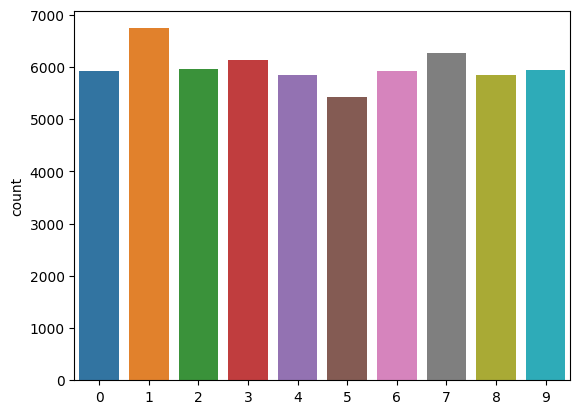

In [25]:
sns.countplot(x=Y)

### Show some images

In [26]:
def plot_random_images(X,Y, nrows=3, ncols=3, real_lables = None):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    n = nrows * ncols

    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    idx = idx[:n]

    X = X[idx]
    Y = Y[idx]

    if real_lables is not None:
        real_lables = real_lables[idx]
    
    i = 0
    for row in axes:
        for cell in row:
            img = X[i].reshape(28,28)
            cell.imshow(img,cmap="gray")
            if real_lables is None:
                cell.set_title(f"Label = {Y[i]}")
            else:
                cell.set_title(f"Label = {Y[i]} \n Real Label = {real_lables[i]}")
            i += 1

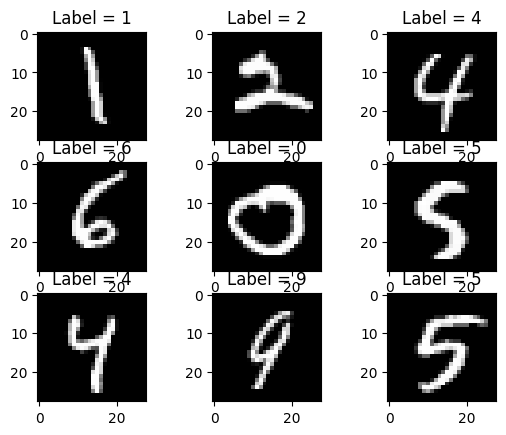

In [27]:
plot_random_images(X,Y)

In [28]:
X = X / 255.0

In [29]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size=0.2,stratify=Y)

In [31]:
params, history, real_grads, approx_grads = train(
    X_train, 
    y_train, 
    test_set=(X_test,y_test),
    eta=0.01, 
    epochs=50,
    batch_size=64,
    nh=64
)

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/750 [00:00<?, ?it/s]

## Learning graph


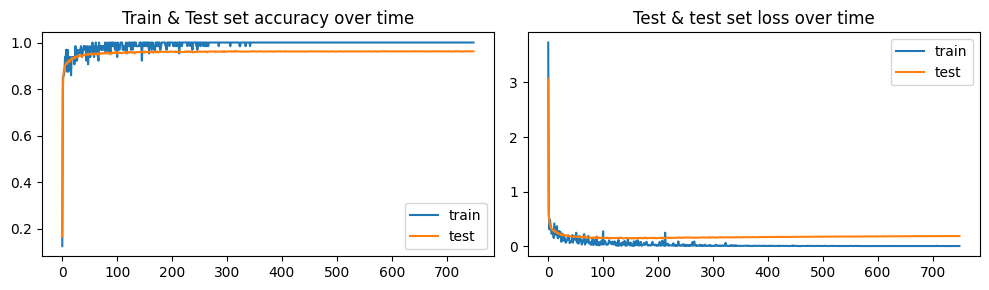

In [32]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)

fig.set_size_inches(10,3)

ax1.plot(np.arange(len(history['accuracy'])),history['accuracy'], label="train")
ax2.plot(np.arange(len(history['loss'])),history['loss'],label="train")

ax1.set_title("Train & Test set accuracy over time")

ax1.plot(np.arange(len(history['test accuracy'])),history['test accuracy'], label='test')
ax2.plot(np.arange(len(history['test loss'])),history['test loss'], label="test")

ax2.set_title("Test & test set loss over time")

ax1.legend()
ax2.legend()

plt.tight_layout()

### Explanation of the Learning Curves
1. **Left Plot (Accuracy Over Time)**
   * The blue curve represents training accuracy.
   * The orange curve represents test accuracy.
   * Both curves increase rapidly at the beginning and then stabilize close to 1.0.
   * This indicates that your model is learning well and generalizing effectively.
2. **Right Plot (Loss Over Time)**
   * The blue curve represents training loss.
   * The orange curve represents test loss.
   * Both losses drop sharply in the early epochs and then stabilize at low values.
   * This suggests the model is minimizing the error successfully.


### Observations
* **Good Convergence**: The training and test accuracy stabilize near 1.0, showing that the MLP has effectively learned the digit recognition task.
* **No Overfitting**: The test accuracy remains close to training accuracy, indicating that the model generalizes well.
* **Smooth Loss Reduction**: The loss curves decline steadily without major fluctuations, suggesting stable optimization.


## Evaluation

In [36]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

In [37]:
y_train_hat = predict(params, X_train)
y_test_hat = predict(params, X_test)

In [38]:
def get_matrics(y, y_hat):
    
    accuracy = accuracy_score(y, y_hat)
    f1 = f1_score(y, y_hat, average="macro")
    precision = precision_score(y, y_hat, average="macro")
    recall = recall_score(y, y_hat, average="macro")

    return pd.Series({
        "accuracy":accuracy,
        "f1_score":f1,
        "precision":precision,
        "recall":recall
    })

In [39]:
train_metrics = get_matrics(y_train, y_train_hat)
test_metrics = get_matrics(y_test, y_test_hat)
metrics = pd.DataFrame(data={
    "train": train_metrics,
    "test":test_metrics
})

In [40]:
metrics

,train,test
accuracy,1.0,0.962167
f1_score,1.0,0.961739
precision,1.0,0.961787
recall,1.0,0.961758


In [41]:
def plot_confusion_matrix(y, y_hat):
    cm = confusion_matrix(y, y_hat)
    ax = sns.heatmap(data=cm, annot=True,cmap='Blues', fmt=',d')
    ax.get_figure().set_size_inches(10,10)
    return ax

Text(0.5, 1.0, 'Train set confusion matrix')

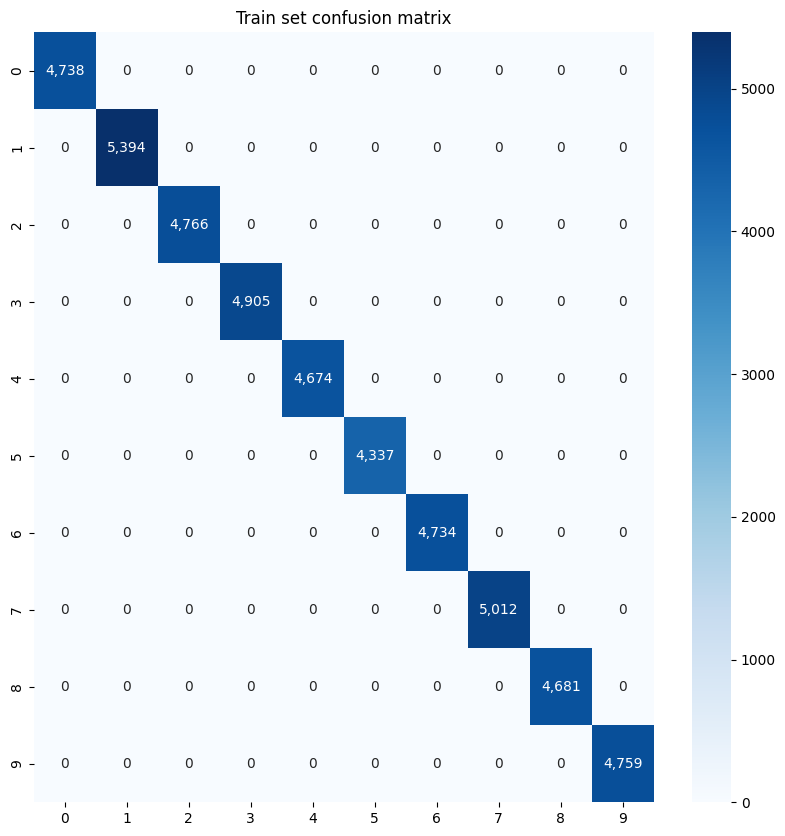

In [42]:
ax = plot_confusion_matrix(y_train, y_train_hat)
ax.set_title("Train set confusion matrix")

Text(0.5, 1.0, 'Test set confusion matrix')

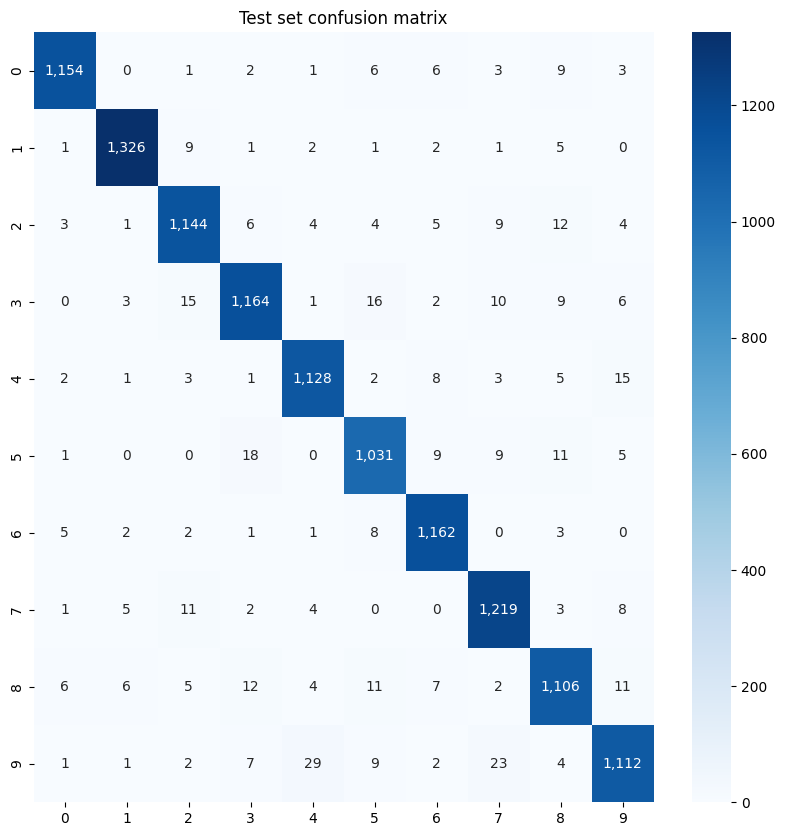

In [43]:
ax = plot_confusion_matrix(y_test, y_test_hat)
ax.set_title("Test set confusion matrix")

### Explanation of the Train and test Set Confusion Matrix

**Observations**:
 * The matrix is nearly diagonal, meaning almost all predictions are correct.
 * The numbers on the diagonal indicate that the model correctly classified almost every sample for each digit.
 * There are **zero misclassifications**, meaning the model has 100% **accuracy on the training set**.
 * Unlike the training set, this matrix is not perfectly diagonal—some misclassifications are present.
 * The diagonal elements still contain high values, meaning the majority of the test samples were classified correctly.

**Common Misclassifications:** <br>
Digit 9 → 4, 5 <br>
Digit 5 → 3, 8 <br>
Digit 3 → 2, 5 <br>
Digit 8 → 3, 5 <br>
These errors are expected since some handwritten numbers look similar.

## Error analysis


In [44]:
X_test_ = X_test[y_test_hat != y_test]
y_test_ = y_test[y_test_hat != y_test]
y_test_hat_ = y_test_hat[y_test_hat != y_test]

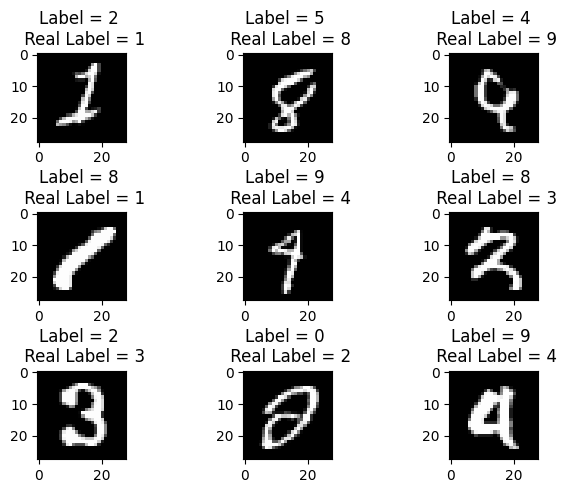

In [45]:
plot_random_images(X_test_,y_test_hat_,real_lables=y_test_)
plt.tight_layout(pad=0.25)